# **Exploratory Data Analysis & Preprocessing**

Install and load all the necessary dependancies

In [1]:
!pip install wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 76.4 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.
cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.3 which is incompatible.
dask-cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.3 which is incompatible.


In [133]:
import os
import wfdb
from tqdm import tqdm
import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy as sp
from scipy.signal import butter, filtfilt, find_peaks
from collections import defaultdict
from sklearn.model_selection import train_test_split

Load MIT-BIH Arrhythmia Dataset v-1.0.0. Also, we construct the rhythm dictionary based on the .atr files of each recording. Each key of the dictionary should have the following format:

{...,

ID_i: [(Label_1, Timestamp_1), (Label_2, Timestamp_2), (Label_3, Timestamp_3), (Label_4, Timestamp_4),

...}

In [4]:
data_directory = r'/content/drive/MyDrive/mit-bih-arrhythmia-database-1.0 (1).0/mit-bih-arrhythmia-database-1.0.0'

def time_to_seconds(t_str):
    """ 'mm:ss' -> seconds"""
    m, s = map(int, t_str.split(':'))
    return m * 60 + s

def extract_segments_from_rhythm(signal, fs, rhythm_info):
    segments = []
    labels = []

    current_start = 0
    for rhythm_symbol, duration_str in rhythm_info:
        duration_sec = time_to_seconds(duration_str)
        duration_samples = int(duration_sec * fs)
        current_end = current_start + duration_samples

        if current_end > len(signal):
            current_end = len(signal)

        segment = signal[current_start:current_end]

        if len(segment) > 0:
            segments.append(segment)
            labels.append(rhythm_symbol)

        current_start = current_end

        if current_start >= len(signal):
            break

    return segments, labels


# Extract true segments and labels from all the records
all_segments, all_labels = [], []

for rid, sig in tqdm(zip(record_ids, ecg_recordings),
                     total=len(record_ids), ncols=80, desc="Processing records"):

    rhythm_info = rhythm_dict[rid]  # list with tuples (label, "mm:ss")
    segments, labels = extract_segments_from_rhythm(sig, fs, rhythm_info)

    all_segments.extend(segments)
    all_labels.extend(labels)

rhythm_segments = pd.DataFrame({
    "record_id": np.repeat(record_ids, [len(rhythm_dict[r]) for r in record_ids]),
    "rhythm_label": all_labels,
    "duration": [len(seg)/fs for seg in all_segments]
})

Loading ECG records: 100%|██████████████████████| 48/48 [00:42<00:00,  1.14it/s]


Unique recording durations (samples):
650000.00


In [3]:
# Rhythm dictionary
rhythm_dict = {
    '100': [('N', '30:06')],
    '101': [('N', '30:06')],
    '102': [('N', '1:22'), ('P', '28:44')],
    '103': [('N', '30:06')],
    '104': [('N', '3:52'), ('P', '26:13')],
    '105': [('N', '30:06')],
    '106': [('N', '22:36'), ('B', '7:15'), ('T', '0:13'), ('VT', '0:02')],
    '107': [('P', '30:06')],
    '108': [('N', '30:06')],
    '109': [('N', '30:06')],
    '111': [('N', '30:06')],
    '112': [('N', '30:06')],
    '113': [('N', '30:06')],
    '114': [('N', '30:01'), ('SVTA', '0:05')],
    '115': [('N', '30:06')],
    '116': [('N', '30:06')],
    '117': [('N', '30:06')],
    '118': [('N', '30:06')],
    '119': [('N', '22:36'), ('B', '3:55'), ('T', '3:34')],
    '121': [('N', '30:06')],
    '122': [('N', '30:06')],
    '123': [('N', '30:06')],
    '124': [('N', '28:36'), ('NOD', '0:30'), ('T', '0:22'), ('IVR', '0:37')],
    '200': [('N', '15:58'), ('B', '13:52'), ('VT', '0:15')],
    '201': [('N', '12:57'), ('SVTA', '0:02'), ('AFIB', '10:06'), ('NOD', '0:24'), ('T', '6:37')],
    '202': [('N', '19:31'), ('AFL', '0:48'), ('AFIB', '9:46')],
    '203': [('N', '2:43'), ('AFL', '5:14'), ('AFIB', '21:32'), ('T', '0:04'), ('VT', '0:33')],
    '205': [('N', '29:43'), ('VT', '0:23')],
    '207': [('N', '22:20'), ('SVTA', '0:52'), ('B', '2:38'), ('IVR', '1:49'), ('VT', '0:03'), ('VFL', '2:24')],
    '208': [('N', '24:43'), ('T', '5:22')],
    '209': [('N', '28:23'), ('SVTA', '1:42')],
    '210': [('AFIB', '29:30'), ('B', '0:23'), ('T', '0:07'), ('VT', '0:06')],
    '212': [('N', '30:06')],
    '213': [('N', '29:01'), ('B', '1:00'), ('VT', '0:04')],
    '214': [('N', '28:53'), ('T', '1:08'), ('VT', '0:05')],
    '215': [('N', '30:03'), ('VT', '0:02')],
    '217': [('AFIB', '4:12'), ('P', '25:10'), ('B', '0:42'), ('VT', '0:02')],
    '219': [('N', '6:01'), ('AFIB', '23:47'), ('B', '0:08'), ('T', '0:10')],
    '220': [('N', '29:50'), ('SVTA', '0:16')],
    '221': [('AFIB', '29:17'), ('B', '0:03'), ('T', '0:42'), ('VT', '0:04')],
    '222': [('N', '15:57'), ('AB', '1:28'), ('SVTA', '0:08'), ('AFL', '7:03'), ('AFIB', '1:44'), ('NOD', '3:45')],
    '223': [('N', '23:23'), ('B', '4:19'), ('T', '0:38'), ('VT', '1:46')],
    '228': [('N', '24:17'), ('B', '5:48')],
    '230': [('N', '17:45'), ('PREX', '12:21')],
    '231': [('N', '18:26'), ('BII', '11:40')],
    '232': [('SBR', '30:06')],
    '233': [('N', '28:03'), ('B', '1:48'), ('T', '0:04'), ('VT', '0:11')],
    '234': [('N', '29:40'), ('SVTA', '0:26')]
}

In [172]:
ecg_recordings = []
durations = []
record_ids = list(rhythm_dict.keys())

for rid in tqdm(record_ids, desc="Loading ECG records", ncols=80):
    rec_path = os.path.join(data_directory, rid)
    rec = wfdb.rdrecord(rec_path)
    sig = rec.p_signal[:, 0].astype(np.float64)
    ecg_recordings.append(sig)

    # Store the number of samples per recording
    durations.append(len(sig))

# Check if all have the same amount of samples (duration)
unique_durations = sorted(set(np.round(durations, 2)))
print("\nUnique recording durations (samples):")
for d in unique_durations:
    print(f"{d:.2f}")

Loading ECG records: 100%|██████████████████████| 48/48 [00:02<00:00, 20.93it/s]


Unique recording durations (samples):
650000.00


Then, we plot the ECG recordings of the first 4 patients (record IDs). Since all recordings are padded to fixed size of **650,000 samples** and the **sampling rate** is set to **360 Hz**, then the duration is equal to:

$$
\text{duration} =
\frac{\text{number of samples}}{\text{sampling frequency}} =
\frac{650,000}{360} \approx 1,805.56~\text{seconds} \approx 30~\text{minutes}
$$

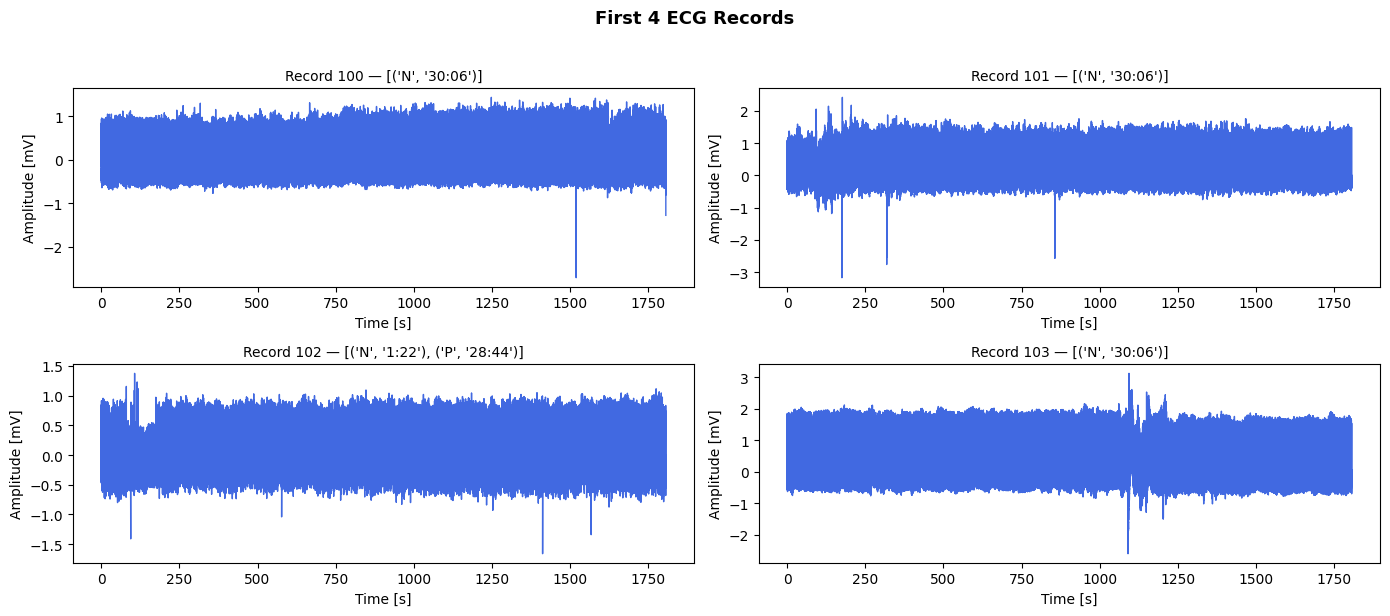

In [5]:
fs = 360  # Sampling rate (Hz)
k = 4     # First 4 recordings

selected_ids = record_ids[:k]
selected_signals = ecg_recordings[:k]

# Plot
n_cols = 2
n_rows = int(np.ceil(k / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 3 * n_rows), sharex=False)
axes = axes.flatten()

for idx, (rid, sig) in enumerate(zip(selected_ids, selected_signals)):
    t = np.arange(len(sig)) / fs
    axes[idx].plot(t, sig, color='royalblue', linewidth=1)
    axes[idx].set_title(f"Record {rid} — {rhythm_dict[rid]}", fontsize=10)
    axes[idx].set_xlabel("Time [s]")
    axes[idx].set_ylabel("Amplitude [mV]")

for j in range(len(selected_ids), len(axes)):
    axes[j].axis('off')

plt.suptitle(f"First {k} ECG Records",
             fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [6]:
# Convert signals into an array
arr = np.vstack([sig for sig in ecg_recordings])

print(arr.shape)

(48, 650000)


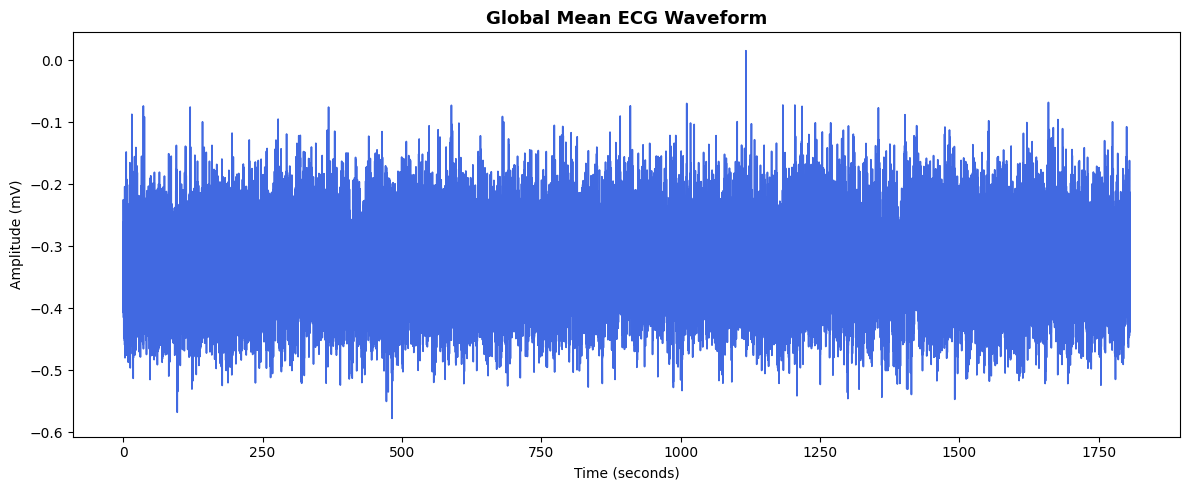

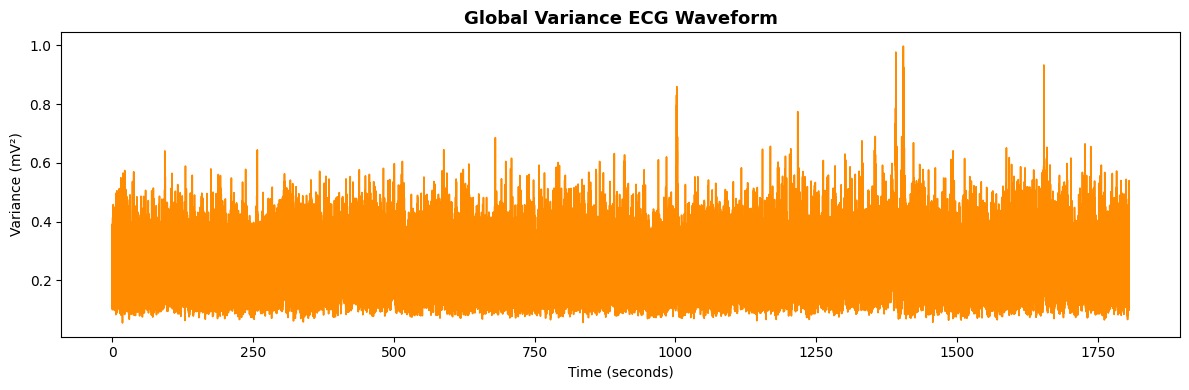

In [7]:
# Compute mean and variance waveforms
mean_wave = arr.mean(axis=0)
var_wave = arr.var(axis=0)

# Mean waveform
plt.figure(figsize=(12, 5))
plt.plot(t, mean_wave, color='royalblue', linewidth=1.2)
plt.title(f"Global Mean ECG Waveform", fontsize=13, fontweight='bold')
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude (mV)")
plt.tight_layout()
plt.show()

# Variance waveform
plt.figure(figsize=(12, 4))
plt.plot(t, var_wave, color='darkorange', linewidth=1.2)
plt.title(f"Global Variance ECG Waveform", fontsize=13, fontweight='bold')
plt.xlabel("Time (seconds)")
plt.ylabel("Variance (mV²)")
plt.tight_layout()
plt.show()

For simplicity we focus on the first 3,600 samples (10 s) for the rest of the visualization.

###**Remove DC bias**

Removing DC bias from ECG recordings: 100%|████| 48/48 [00:00<00:00, 220.58it/s]


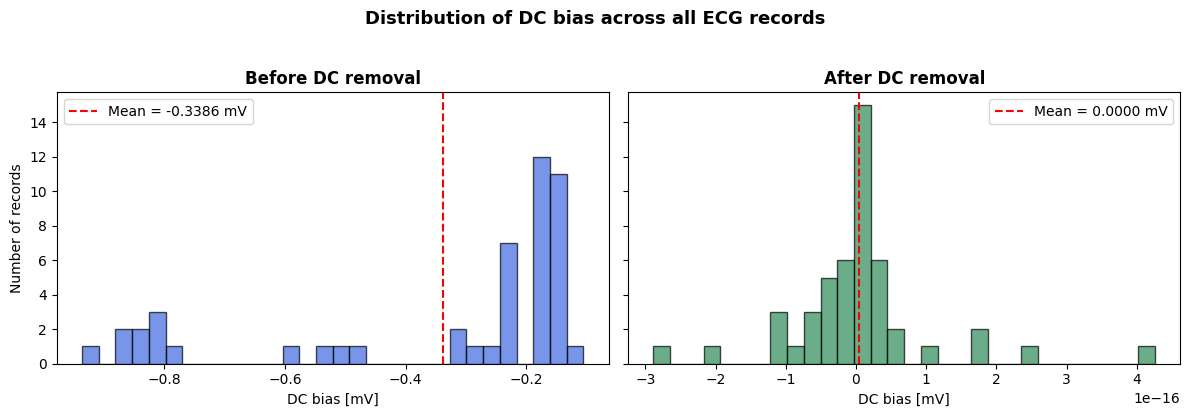

In [8]:
dc_before, dc_after = [], []
signals_before, signals_after = [], []

for sig in tqdm(ecg_recordings, desc="Removing DC bias from ECG recordings", ncols=80):
    # Calculate DC offset (mean value)
    dc_val = np.mean(sig)

    # Subtract DC
    sig_corrected = sig - dc_val

    # Save the corrected signals
    dc_before.append(dc_val)
    dc_after.append(np.mean(sig_corrected))
    signals_before.append(sig)
    signals_after.append(sig_corrected)

# Convert to numpy arrays
dc_before = np.array(dc_before)
dc_after = np.array(dc_after)

# Plot DC distribution before and after the correction
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# Before
axes[0].hist(dc_before, bins=30, color='royalblue', alpha=0.7, edgecolor='black')
axes[0].axvline(np.mean(dc_before), color='red', linestyle='--', label=f"Mean = {np.mean(dc_before):.4f} mV")
axes[0].set_title("Before DC removal", fontsize=12, fontweight='bold')
axes[0].set_xlabel("DC bias [mV]")
axes[0].set_ylabel("Number of records")
axes[0].legend()

# After
axes[1].hist(dc_after, bins=30, color='seagreen', alpha=0.7, edgecolor='black')
axes[1].axvline(np.mean(dc_after), color='red', linestyle='--', label=f"Mean = {np.mean(dc_after):.4f} mV")
axes[1].set_title("After DC removal", fontsize=12, fontweight='bold')
axes[1].set_xlabel("DC bias [mV]")
axes[1].legend()

plt.suptitle("Distribution of DC bias across all ECG records", fontsize=13, fontweight='bold', y=1.03)
plt.tight_layout()
plt.show()

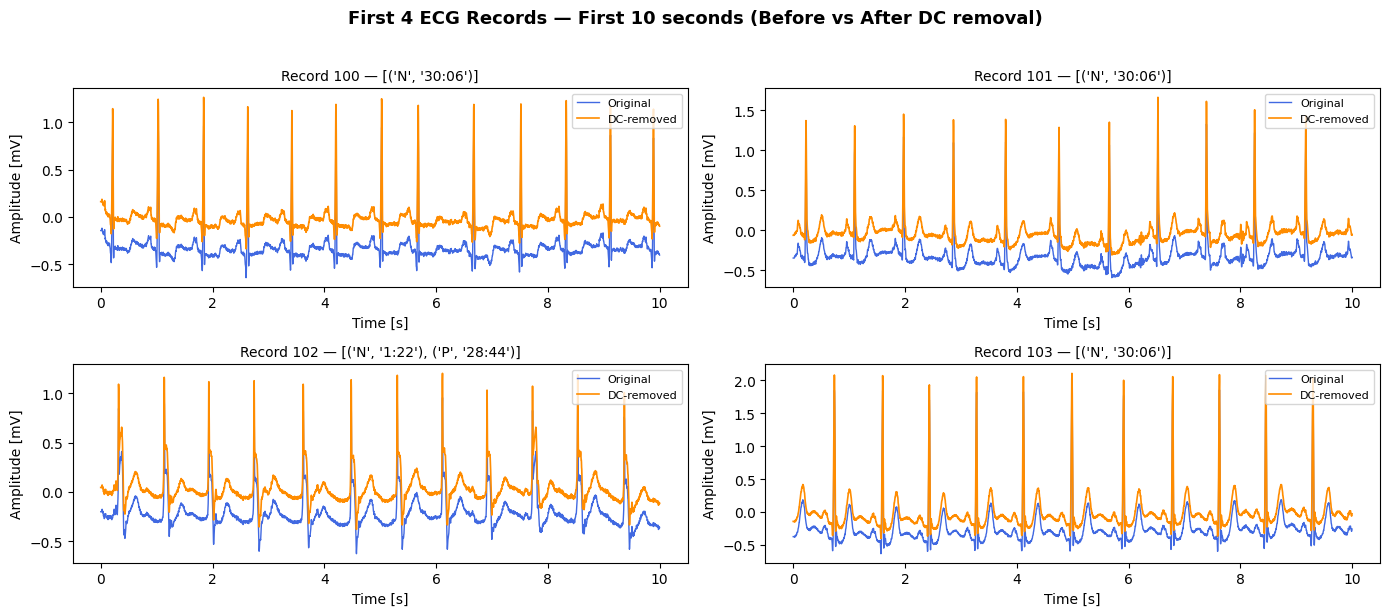

In [9]:
m = 3600 # 10 seconds (samples = 10 * fs)

selected_ids = record_ids[:k]
selected_before = signals_before[:k]
selected_after = signals_after[:k]

# Plot
n_cols = 2
n_rows = int(np.ceil(k / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 3 * n_rows), sharex=False)
axes = axes.flatten()

for idx, (rid, sig_before, sig_after) in enumerate(zip(selected_ids, selected_before, selected_after)):
    sig_before_10s = sig_before[:m]
    sig_after_10s = sig_after[:m]
    t = np.arange(m) / fs

    # Plot before & after
    axes[idx].plot(t, sig_before_10s, label="Original", color='royalblue', linewidth=1)
    axes[idx].plot(t, sig_after_10s, label="DC-removed", color='darkorange', linewidth=1.2)
    axes[idx].set_title(f"Record {rid} — {rhythm_dict[rid]}", fontsize=10)
    axes[idx].set_xlabel("Time [s]")
    axes[idx].set_ylabel("Amplitude [mV]")
    axes[idx].legend(loc='upper right', fontsize=8)

for j in range(len(selected_ids), len(axes)):
    axes[j].axis('off')

plt.suptitle(f"First {k} ECG Records — First 10 seconds (Before vs After DC removal)",
             fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### **Apply bandpass filtering**

Filtering ECG recordings: 100%|█████████████████| 48/48 [00:01<00:00, 45.75it/s]


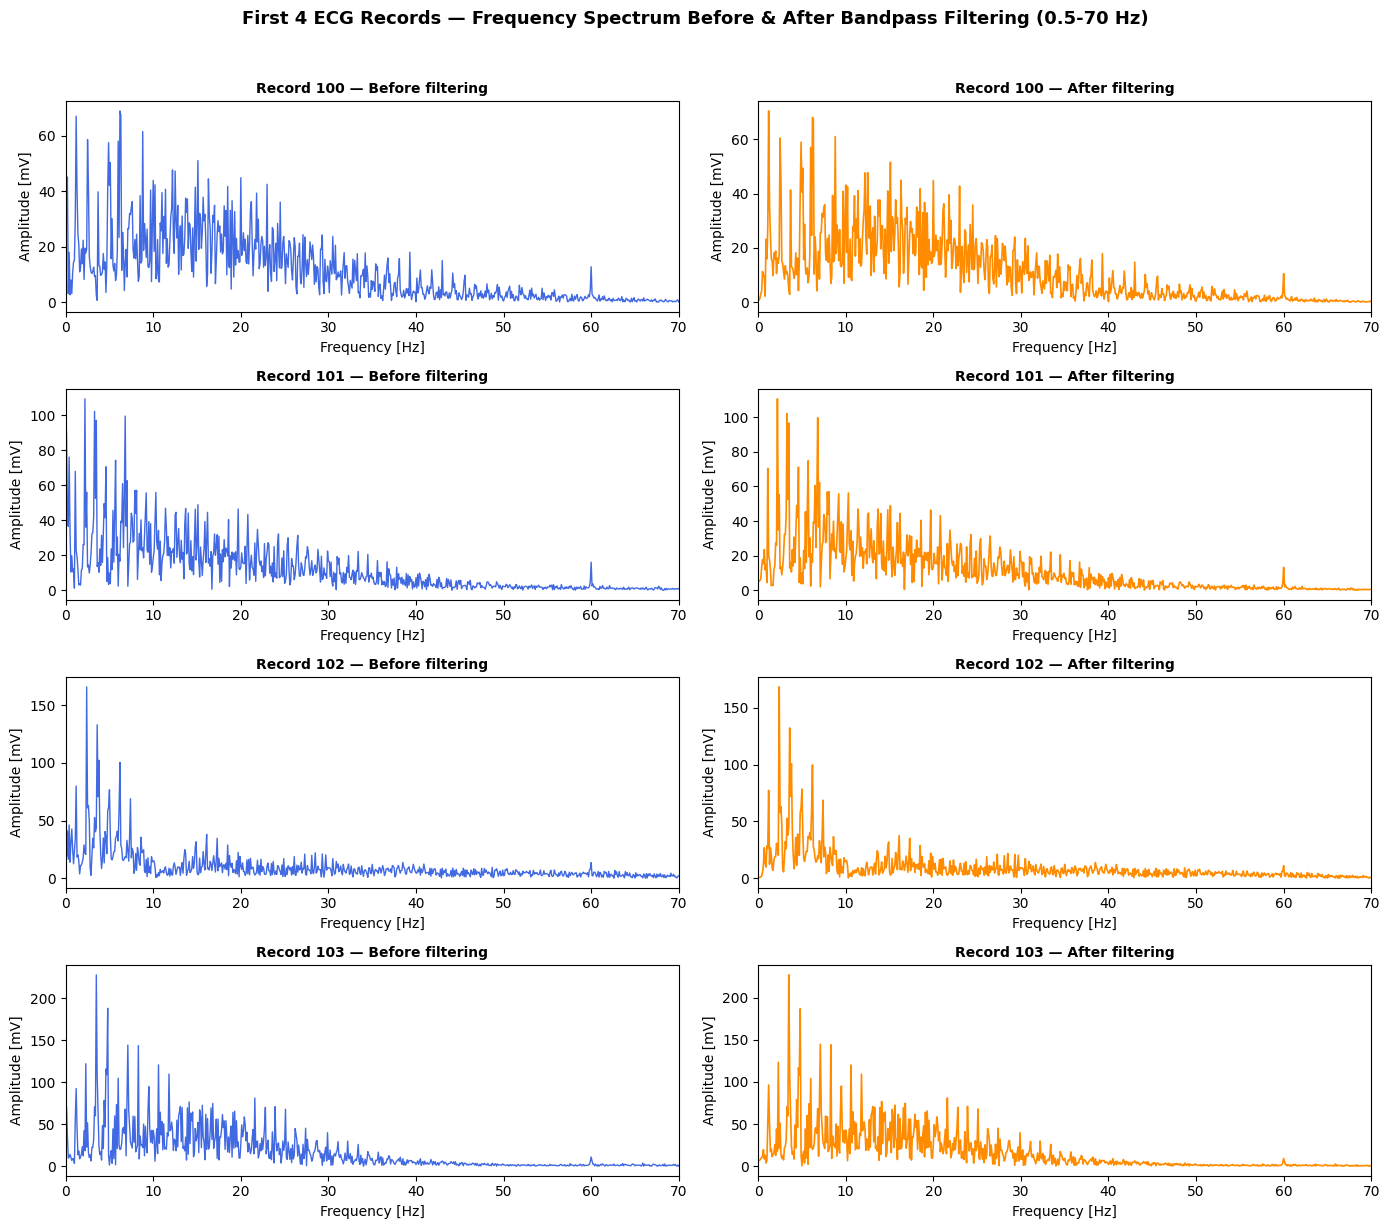

In [10]:
# Bandpass filter definition
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

# FFT utility
def get_frequency_spectrum(signal, fs, fmin, fmax):
    fft_data = np.fft.fft(signal)
    freqs = np.fft.fftfreq(len(signal), d=1/fs)

    # Positive frequencies only
    pos_freqs = freqs[:len(freqs)//2]
    amplitudes = np.abs(fft_data[:len(fft_data)//2])

    # Correct frequency range filter
    freq_range = (pos_freqs >= fmin) & (pos_freqs <= fmax)
    filtered_frequencies = pos_freqs[freq_range]
    filtered_fft_data = amplitudes[freq_range]

    return filtered_frequencies, filtered_fft_data

lowcut = 0.5
highcut = 70

# Apply filter to all DC-corrected signals
filtered_signals = []
for sig in tqdm(signals_after, desc="Filtering ECG recordings", ncols=80):
    filtered = bandpass_filter(sig, lowcut, highcut, fs)
    filtered_signals.append(filtered)

# Plot frequency spectra before and after filtering
selected_ids = record_ids[:k]
selected_before = signals_after[:k]
selected_after_filter = filtered_signals[:k]

n_cols = 2
n_rows = int(np.ceil(k))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 3 * n_rows), sharex=False)
axes = axes.reshape(n_rows, n_cols)

for idx, (rid, sig_before, sig_after) in enumerate(zip(selected_ids, selected_before, selected_after_filter)):
    sig_before_10s = sig_before[:m]
    sig_after_10s = sig_after[:m]

    freqs_before, amp_before = get_frequency_spectrum(sig_before_10s, fs, 0, 70)
    freqs_after, amp_after = get_frequency_spectrum(sig_after_10s, fs, 0, 70)

    axes[idx, 0].plot(freqs_before, amp_before, color='royalblue', linewidth=1)
    axes[idx, 0].set_xlim(0, 70)
    axes[idx, 0].set_title(f"Record {rid} — Before filtering", fontsize=10, fontweight='bold')
    axes[idx, 0].set_xlabel("Frequency [Hz]")
    axes[idx, 0].set_ylabel("Amplitude [mV]")

    axes[idx, 1].plot(freqs_after, amp_after, color='darkorange', linewidth=1.2)
    axes[idx, 1].set_xlim(0, 70)
    axes[idx, 1].set_title(f"Record {rid} — After filtering", fontsize=10, fontweight='bold')
    axes[idx, 1].set_xlabel("Frequency [Hz]")
    axes[idx, 1].set_ylabel("Amplitude [mV]")

plt.suptitle(f"First {k} ECG Records — Frequency Spectrum Before & After Bandpass Filtering ({lowcut}-{highcut} Hz)",
             fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


###**Apply Notch filter**

The frequency spectra clearly reveal an anomalous amplitude at 60 Hz for most of the cases.

Applying Notch filter: 100%|████████████████████| 48/48 [00:00<00:00, 78.33it/s]


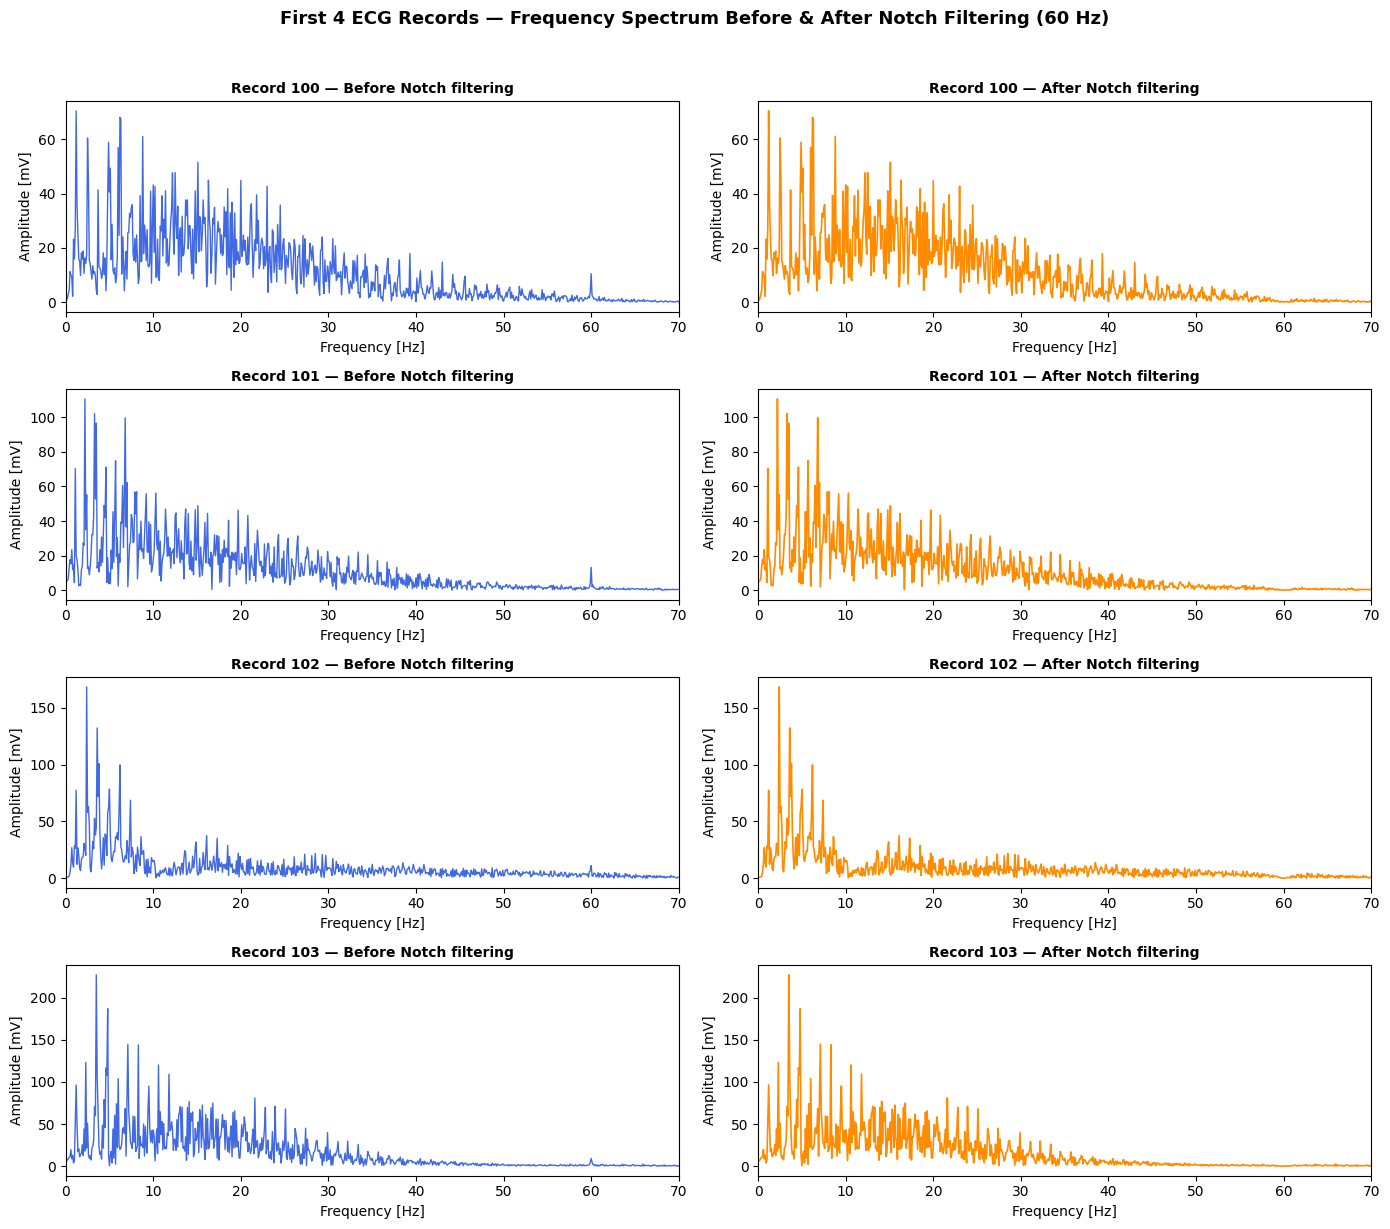

In [11]:
# Notch filter definition
def notch_filter(signal, notch_frequency, quality_factor, fs):
  # Calculate the notch filter coefficients
  b, a = sp.signal.iirnotch(notch_frequency / (fs / 2), quality_factor)

  # Filters the signal to remove 60 Hz interference
  return sp.signal.filtfilt(b, a, signal)

notch_freq = 60
q_factor = 30 # Quality factor (30–50)

# Apply Notch filter to bandpass-filtered signals
notch_filtered_signals = []

for sig in tqdm(filtered_signals, desc="Applying Notch filter", ncols=80):
    filtered = notch_filter(sig, notch_freq, q_factor, fs)
    notch_filtered_signals.append(filtered)

# Plot frequency spectra before and after Notch filtering
selected_ids = record_ids[:k]
selected_before = filtered_signals[:k]
selected_after_notch = notch_filtered_signals[:k]

n_cols = 2
n_rows = int(np.ceil(k))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 3 * n_rows), sharex=False)
axes = axes.reshape(n_rows, n_cols)

for idx, (rid, sig_before, sig_after) in enumerate(zip(selected_ids, selected_before, selected_after_notch)):
    sig_before_10s = sig_before[:m]
    sig_after_10s = sig_after[:m]

    freqs_before, amp_before = get_frequency_spectrum(sig_before_10s, fs, 0, 70)
    freqs_after, amp_after = get_frequency_spectrum(sig_after_10s, fs, 0, 70)

    axes[idx, 0].plot(freqs_before, amp_before, color='royalblue', linewidth=1)
    axes[idx, 0].set_xlim(0, 70)
    axes[idx, 0].set_title(f"Record {rid} — Before Notch filtering", fontsize=10, fontweight='bold')
    axes[idx, 0].set_xlabel("Frequency [Hz]")
    axes[idx, 0].set_ylabel("Amplitude [mV]")

    axes[idx, 1].plot(freqs_after, amp_after, color='darkorange', linewidth=1.2)
    axes[idx, 1].set_xlim(0, 70)
    axes[idx, 1].set_title(f"Record {rid} — After Notch filtering", fontsize=10, fontweight='bold')
    axes[idx, 1].set_xlabel("Frequency [Hz]")
    axes[idx, 1].set_ylabel("Amplitude [mV]")

plt.suptitle(f"First {k} ECG Records — Frequency Spectrum Before & After Notch Filtering ({notch_freq} Hz)",
             fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### **Split recordings into segments**

- **Using R-peaks**:

Each segment must contain a single heartbeat so we need to identify the R peaks inside it and isolate the regions to the left and right of each R peak based on a standardized distance.

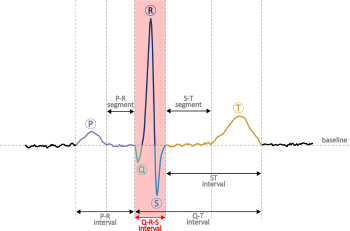

For example, below there are the R peaks of the first recording for the first 10 seconds.

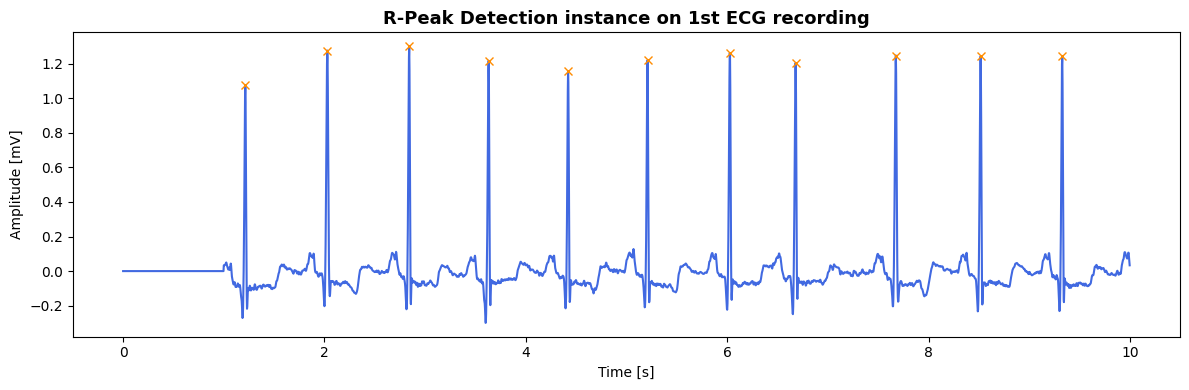

In [31]:
filtered_signal_final = notch_filtered_signals[0]

# Add 1 second (360 samples) using zero padding on the beginning
padding_length = fs
filtered_signal_final_padded = np.concatenate((np.zeros(padding_length), filtered_signal_final))

# Find peaks on the full padded signal
peaks, _ = sp.signal.find_peaks(filtered_signal_final_padded, height=0.5, distance=fs//4)

# Time vector for full signal
t_full = np.arange(len(filtered_signal_final_padded)) / fs

t = t_full[:m]
sig_segment = filtered_signal_final_padded[:m]

# Keep the peaks on range [0, m)
valid_peaks = peaks[peaks < m]

# Plot
plt.figure(figsize=(12, 4))
plt.plot(t, sig_segment, color='royalblue')
plt.plot(t[valid_peaks], sig_segment[valid_peaks], "x", color='darkorange')
plt.title("R-Peak Detection instance on 1st ECG recording", fontsize=13, fontweight='bold')
plt.xlabel("Time [s]")
plt.ylabel("Amplitude [mV]")
plt.tight_layout()
plt.show()

We can also see how the R-peaks of the whole 1st recording are distributed across each segment. Also, the window size of each segment is set to 1s (360 samples). It is obvious that the majority of them is uniformly distributed across the middle of the heartbeat.

Then, we need to extract the valid labels from the rhythm dictionary.

In [179]:
def extract_aami_segments(signal, ann_path, window_size):
    annotation = wfdb.rdann(ann_path, 'atr')
    symbols = annotation.symbol
    samples = annotation.sample

    # Convert WFDB labels to AAMI labels
    aami_labels = [aami_class_of_symbol(sym) for sym in symbols]

    # Define window that contains segments
    half_win = window_size // 2
    segments, labels = [], []

    for s_pos, label in zip(samples, aami_labels):
        start = max(0, s_pos - half_win)
        end = min(len(signal), s_pos + half_win)

        # Extract the segment that corresponds to the AAMI label
        segment = signal[start:end]

        # Ignore if wrong size
        if len(segment) == window_size:
            segments.append(segment)
            labels.append(label)

    return segments, labels

all_segments, all_labels = [], []

for rid, sig in tqdm(zip(record_ids, notch_filtered_signals),
                     total=len(record_ids), desc="Extracting AAMI segments", ncols=80):
    ann_path = os.path.join(data_directory, rid)
    segments, labels = extract_aami_segments(sig, ann_path, window_size=360)
    all_segments.extend(segments)
    all_labels.extend(labels)

Extracting AAMI segments: 100%|█████████████████| 48/48 [00:01<00:00, 38.20it/s]


In [180]:
# Keep first record
first_ann_path = os.path.join(data_directory, record_ids[0])
annotation = wfdb.rdann(first_ann_path, 'atr')
num_segments_first = len(annotation.symbol)

# Extract segments and labels for first record
segments_first = all_segments[:num_segments_first]
labels_first = all_labels[:num_segments_first]

print(f"Record {record_ids[0]} has in total {len(segments_first)} segments")

Record 100 has in total 2274 segments


In [97]:
print(f"Record {record_ids[0]} has {len(sorted(set(labels_first)))} unique labels: {sorted(set(labels_first))}\n")

label_counts = Counter(labels_first)
for lbl, cnt in label_counts.items():
    print(f"  {lbl}: {cnt} segments")

Record 100 has 3 unique labels: ['N', 'S', 'V']

  N: 2240 segments
  S: 33 segments
  V: 1 segments


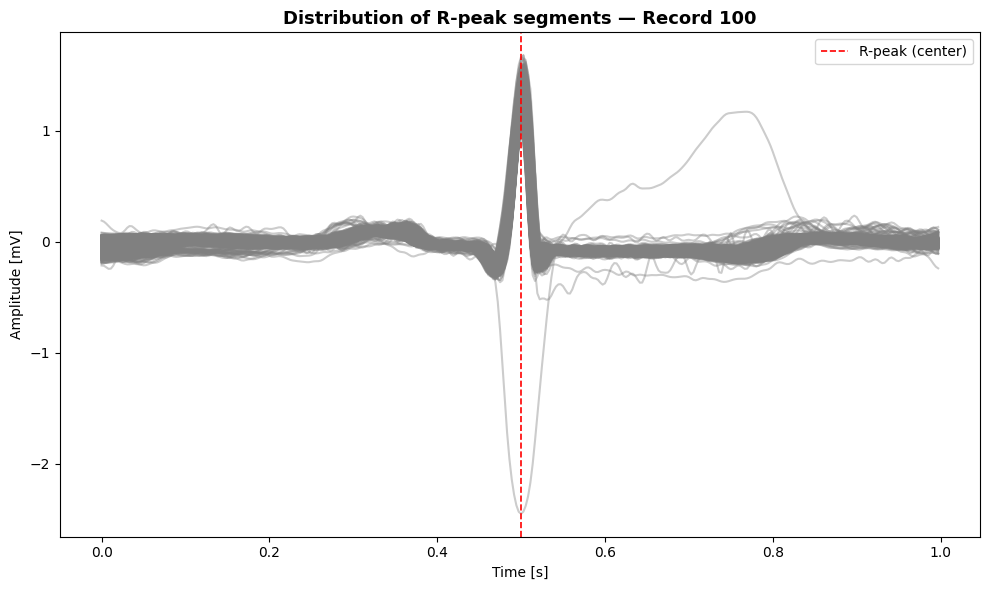

In [161]:
# Time axis
window_size = 360
t = np.arange(window_size) / fs

# Plot R-peak distribution of 1st recording
plt.figure(figsize=(10, 6))

for seg in segments_first:
    plt.plot(t, seg, color='gray', alpha=0.4)

plt.axvline((window_size // 2) / fs, color='red', linestyle='--', linewidth=1.2, label='R-peak (center)')

plt.title(f"Distribution of R-peak segments — Record {record_ids[0]}", fontsize=13, fontweight='bold')
plt.xlabel("Time [s]")
plt.ylabel("Amplitude [mV]")
plt.legend()
plt.tight_layout()
plt.show()

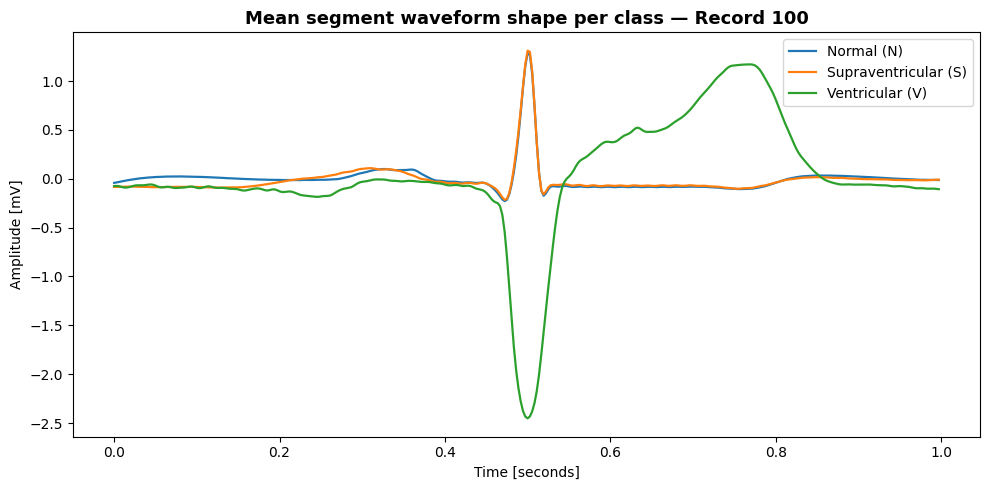

In [99]:
# Group segments of first record per label
buckets = {cls: [] for cls in CLASS_ORDER}
for seg, lbl in zip(segments_first, labels_first):
    if lbl in buckets:
        buckets[lbl].append(seg)

# Mean segment waveform per label
plt.figure(figsize=(10, 5))

for cls in CLASS_ORDER:
    if len(buckets[cls]) == 0:  # Ignore non-existent labels in the first recording
        continue
    arr = np.vstack(buckets[cls]) # [num_beats, window_size]
    mean_wave = arr.mean(axis=0)
    plt.plot(t, mean_wave, linewidth=1.6, label=CLASS_NAMES[cls])

plt.title(f"Mean R-peak segment waveform shape per class — Record {first_id}", fontsize=13, fontweight="bold")
plt.xlabel("Time [seconds]")
plt.ylabel("Amplitude [mV]")
plt.legend()
plt.tight_layout()
plt.show()

Then, we visualize

/tmp/ipython-input-3813824188.py:13: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


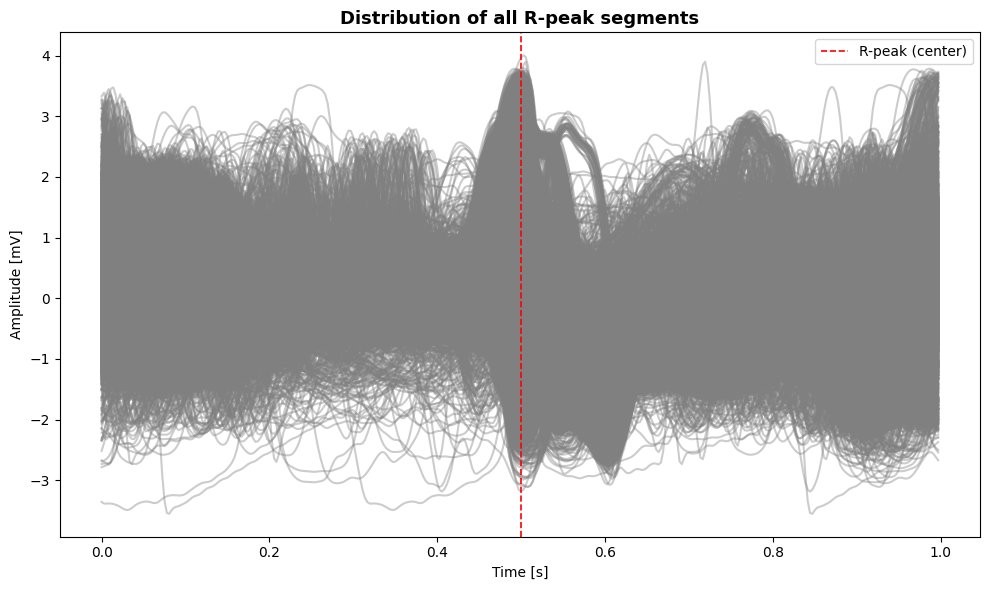

In [166]:
# Plot R-peak distribution of all recordings
plt.figure(figsize=(10, 6))

for seg in all_segments:
    plt.plot(t, seg, color='gray', alpha=0.4)

plt.axvline((window_size // 2) / fs, color='red', linestyle='--', linewidth=1.2, label='R-peak (center)')

plt.title(f"Distribution of all R-peak segments", fontsize=13, fontweight='bold')
plt.xlabel("Time [s]")
plt.ylabel("Amplitude [mV]")
plt.legend()
plt.tight_layout()
plt.show()

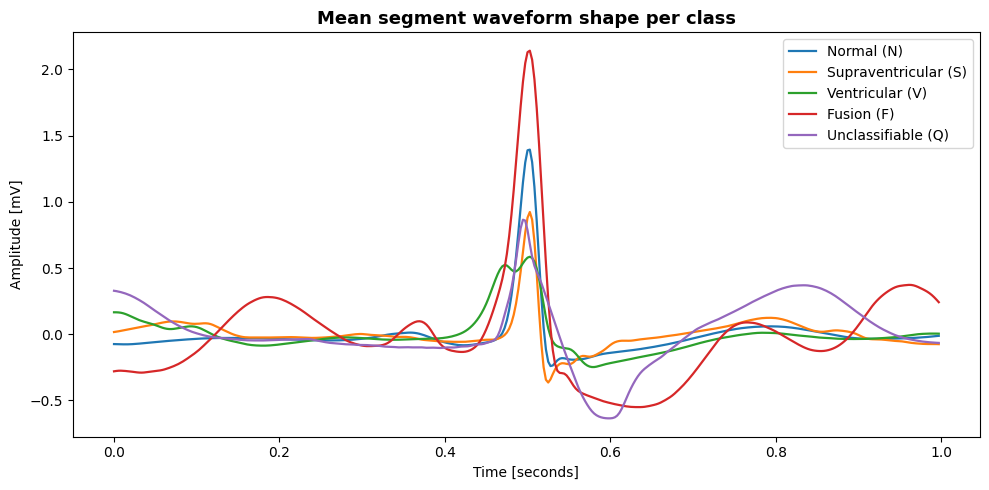

In [100]:
# Group segments per label
buckets = {cls: [] for cls in CLASS_ORDER}
for seg, lbl in zip(all_segments, all_labels):
    if lbl in buckets:
        buckets[lbl].append(seg)

# Mean segment waveform per label
plt.figure(figsize=(10, 5))
for cls in CLASS_ORDER:
    arr = np.vstack(buckets[cls])
    mean_wave = arr.mean(axis=0)
    plt.plot(t, mean_wave, linewidth=1.6, label=CLASS_NAMES[cls])

plt.title("Mean R-peak segment waveform shape per class from all segments", fontsize=13, fontweight="bold")
plt.xlabel("Time [seconds]")
plt.ylabel("Amplitude [mV]")
plt.legend()
plt.tight_layout()
plt.show()

- **Using sliding window**:

In [143]:
def apply_sliding_window(signal_data, win_size, overlap_ratio):
    step_size = int(win_size * (1 - overlap_ratio))
    # Use stride_tricks for more sufficient segmentation
    windows = np.lib.stride_tricks.sliding_window_view(signal_data, window_shape=win_size)[::step_size]
    return windows

all_sliding_segments = []
overlap_ratio = 0.5  # 50% overlap

for rid, sig in tqdm(zip(record_ids, notch_filtered_signals),
                     total=len(record_ids), desc="Extracting sliding segments", ncols=80):
    ann_path = os.path.join(data_directory, rid)
    sliding_segments = apply_sliding_window(sig, win_size=window_size, overlap_ratio=overlap_ratio)
    all_sliding_segments.extend(sliding_segments)

Extracting sliding segments: 100%|████████████| 48/48 [00:00<00:00, 1175.30it/s]


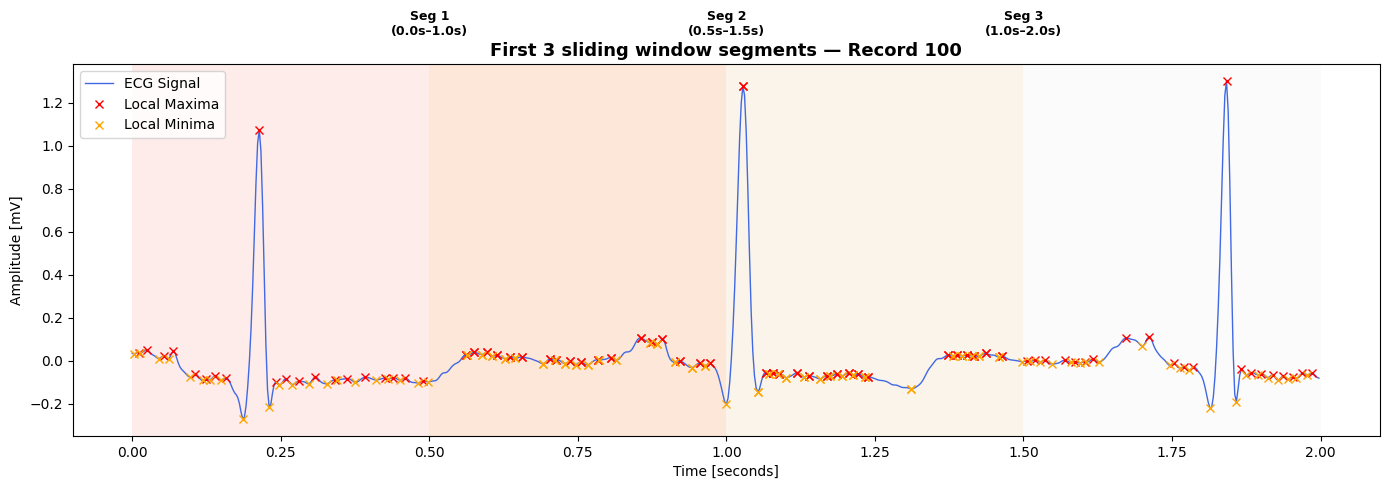

In [173]:
def plot_sliding_segments(signal, segments, fs, win_size=360, overlap_ratio=0.5, n_segments=5, record_id=None):
    step_size = int(win_size * (1 - overlap_ratio))
    segments_to_plot = segments[:n_segments]

    # Δημιουργία συνεχούς σήματος (χωρίς επαναλήψεις)
    total_len = step_size * (len(segments_to_plot) - 1) + win_size
    continuous_signal = signal[:total_len]
    t = np.arange(len(continuous_signal)) / fs

    # Παλέτα χρωμάτων
    colors = plt.cm.Pastel1(np.linspace(0, 1, n_segments))

    plt.figure(figsize=(14, 5))
    plt.plot(t, continuous_signal, color='royalblue', linewidth=1, label='ECG Signal')

    y_top = continuous_signal.max() + 0.2

    for i, seg in enumerate(segments_to_plot):
        start = i * step_size
        end = start + win_size
        start_t = start / fs
        end_t = end / fs

        # Χρωματισμένο φόντο για κάθε segment
        plt.axvspan(start_t, end_t, facecolor=colors[i], alpha=0.25, zorder=0)

        # Peaks / valleys
        peaks, _ = find_peaks(seg)
        valleys, _ = find_peaks(-seg)

        peaks_t = (peaks + start) / fs
        valleys_t = (valleys + start) / fs

        plt.plot(peaks_t, seg[peaks], "x", color='red', label='Local Maxima' if i == 0 else "")
        plt.plot(valleys_t, seg[valleys], "x", color='orange', label='Local Minima' if i == 0 else "")

        # Ετικέτα στο πάνω μέρος του segment
        plt.text(
            (start_t + end_t) / 2,
            y_top,
            f"Seg {i+1}\n({start_t:.1f}s–{end_t:.1f}s)",
            ha='center', va='bottom',
            fontsize=9, color='black', fontweight='bold',
            bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', boxstyle='round,pad=0.3')
        )

    plt.title(f"First {n_segments} sliding window segments — Record {record_id if record_id else ''}",
              fontsize=13, fontweight='bold')
    plt.xlabel("Time [seconds]")
    plt.ylabel("Amplitude [mV]")
    plt.legend()
    plt.tight_layout()
    plt.show()


# === Παράδειγμα χρήσης ===
plot_sliding_segments(
    signal=notch_filtered_signals[0],
    segments=segments_first,
    fs=fs,
    win_size=360,        # 1 sec
    overlap_ratio=0.5,   # 50% overlap
    n_segments=3,
    record_id=record_ids[0]
)


###**Normalize segments**

In [181]:
# Min–Max Normalization with range (0,1)
final_segments = []
for seg in tqdm(all_segments, desc="Normalizing segments", ncols=80):
    seg_min = np.min(seg)
    seg_max = np.max(seg)
    if seg_max - seg_min > 0:
        seg_norm = (seg - seg_min) / (seg_max - seg_min)
    else:
        seg_norm = np.zeros_like(seg)  # skip division with zero for flat signals
    final_segments.append(seg_norm)

Normalizing segments: 100%|██████████| 112544/112544 [00:02<00:00, 53626.61it/s]


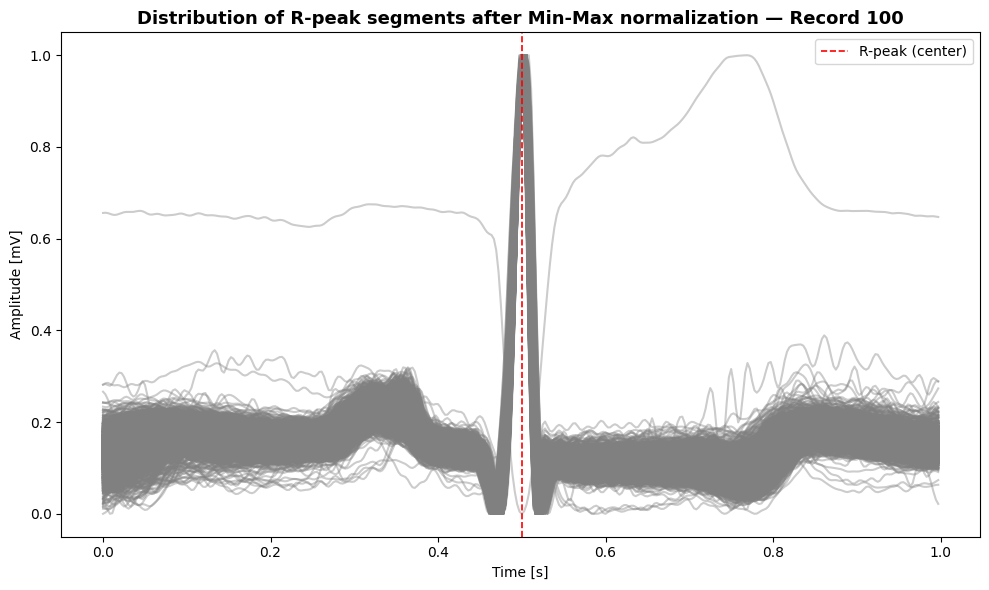

In [184]:
# Plot R-peak distribution of 1st recording after normalization
segments_first = final_segments[:num_segments_first]
labels_first = final_segments[:num_segments_first]

plt.figure(figsize=(10, 6))

for seg in segments_first:
    plt.plot(t, seg, color='gray', alpha=0.4)

plt.axvline((window_size // 2) / fs, color='red', linestyle='--', linewidth=1.2, label='R-peak (center)')

plt.title(f"Distribution of R-peak segments after Min-Max normalization — Record {record_ids[0]}", fontsize=13, fontweight='bold')
plt.xlabel("Time [s]")
plt.ylabel("Amplitude [mV]")
plt.legend()
plt.tight_layout()
plt.show()

###**Handle data imbalance by resampling**

Split the segments into train/val/test sets and check the label distribution across the different segments of training set.

In [111]:
# Convert to NumPy arrays for better handling
X = np.array(final_segments)
y = np.array(all_labels)

# Train / Temp split (80/20)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Temp (20) split to Val / Test (10/10)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# Shapes (#recordings, #samples)
print(f"Train set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

Train set: (90035, 360)
Validation set: (11254, 360)
Test set: (11255, 360)


Visualize the imbalanced distribution of labels in the training set.

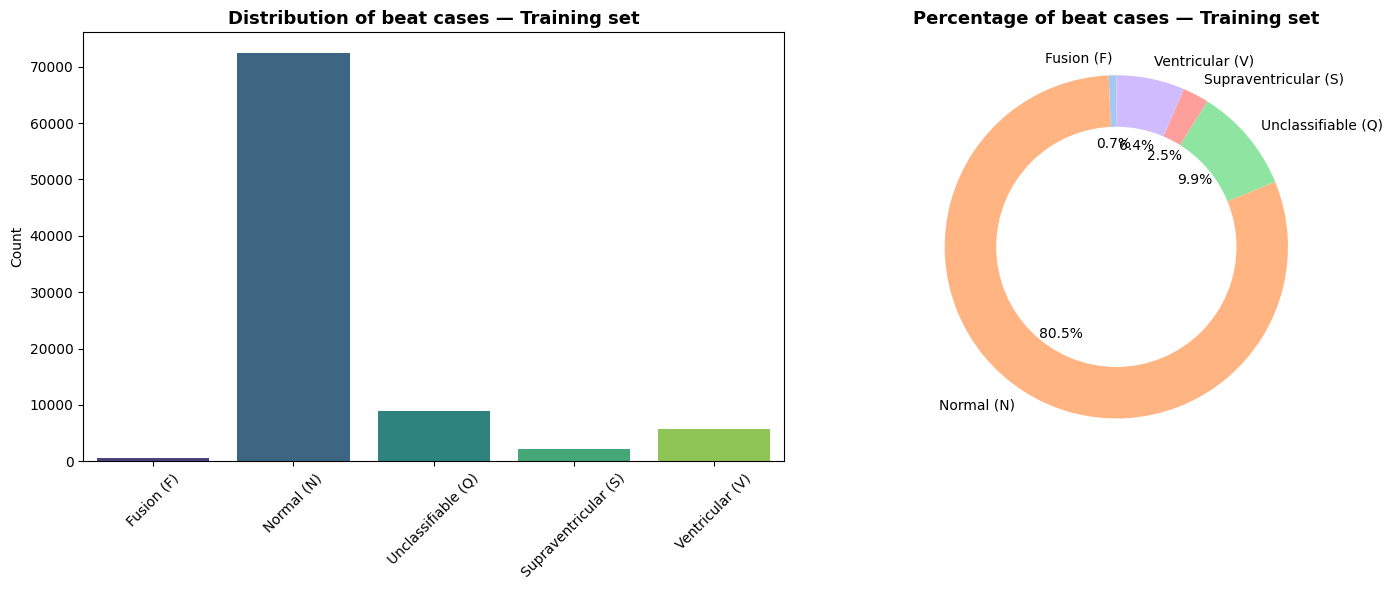

In [112]:
# Convert to Series
y_train_series = pd.Series(y_train, name="AAMI_class")

# Calculate counts per label
num_of_values = y_train_series.value_counts().sort_index()

data_for_plot = pd.DataFrame({
    'Label': [CLASS_NAMES[i] for i in num_of_values.index],
    'Count': num_of_values.values
})

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Bar plot
sns.barplot(
    data=data_for_plot,
    x='Label',
    y='Count',
    hue='Label',
    palette='viridis',
    dodge=False,
    ax=axes[0]
)
axes[0].set_title("Distribution of beat cases — Training set", fontsize=13, fontweight='bold')
axes[0].set_xlabel("")
axes[0].set_ylabel("Count")
axes[0].legend([], [], frameon=False)
axes[0].tick_params(axis='x', rotation=45)

# Pie chart
axes[1].set_title("Percentage of beat cases — Training set", fontsize=13, fontweight='bold')
colors = sns.color_palette('pastel', len(num_of_values))
wedges, texts, autotexts = axes[1].pie(
    num_of_values.values,
    labels=[CLASS_NAMES[i] for i in num_of_values.index],
    autopct='%1.1f%%',
    colors=colors,
    startangle=90
)

centre_circle = plt.Circle((0, 0), 0.7, fc='white')
axes[1].add_artist(centre_circle)

plt.tight_layout()
plt.show()

To handle the imbalance we:

- Downsample the N labels from 70,000 to 20,000

- Augment the F labels using random time shifting and amplitude variation.


Initial training set distribution:
  N: 72465 segments
  S: 2225 segments
  V: 5788 segments
  F: 642 segments
  Q: 8915 segments

Final balanced training set distribution:
  N: 20000 segments
  S: 2225 segments
  V: 5788 segments
  F: 1644 segments
  Q: 8915 segments


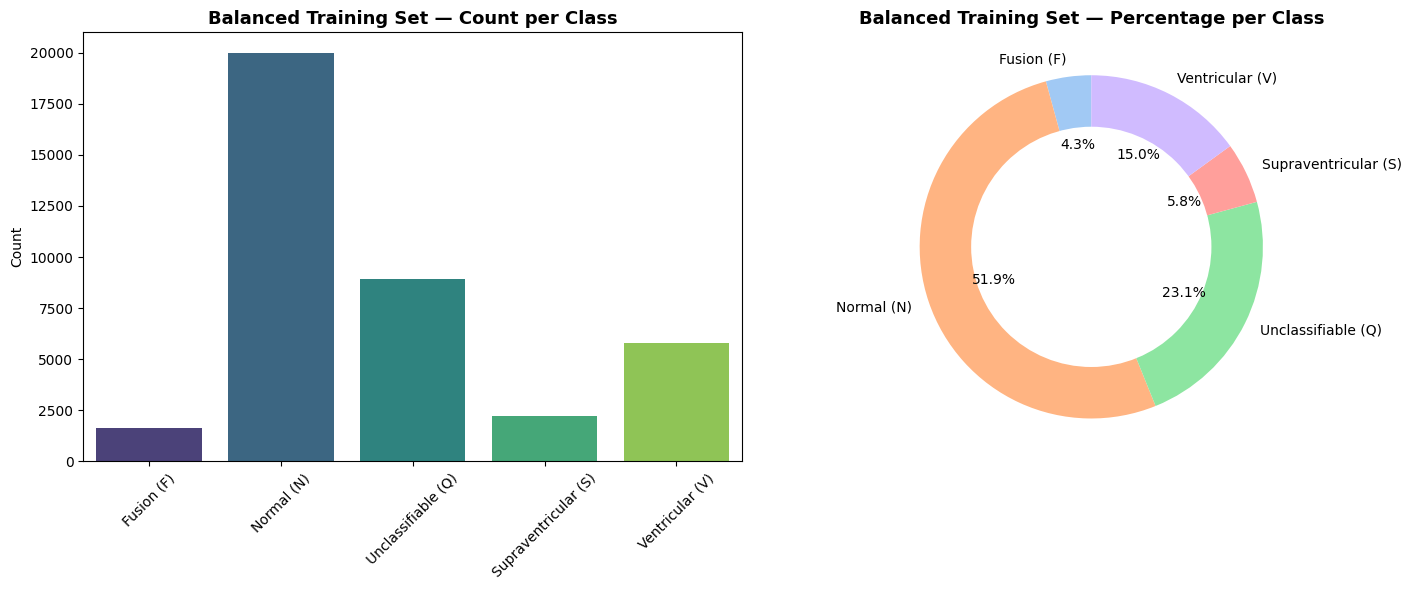

In [120]:
# Augmentation helpers
def circular_time_shift(signal, shift):
    return np.roll(signal, shift)

def amplitude_variation(signal, factor):
    return signal * factor

train_segments_by_class = {cls: [] for cls in CLASS_ORDER}
for seg, lbl in zip(X_train, y_train):
    if lbl in train_segments_by_class:
        train_segments_by_class[lbl].append(seg)

print("\nInitial training set distribution:")
for cls in CLASS_ORDER:
    print(f"  {cls}: {len(train_segments_by_class[cls])} segments")

# Downsample Normal (N) to 20,000 samples
n_target = 20000
if len(train_segments_by_class["N"]) > n_target:
    train_segments_by_class["N"] = random.sample(train_segments_by_class["N"], n_target)

# Augment Fusion (F) class with 1000 more segments
f_segments = train_segments_by_class["F"]

if len(f_segments) > 0:
    # Random time shifting (±5 samples) - 500 new segments
    new_segments_shift = []
    for i in range(501):
        base = random.choice(f_segments)
        shift = random.randint(-5, 5)
        new_segments_shift.append(circular_time_shift(base, shift))

    # Random amplitude scaling (0.9–1.1) - 500 new segments
    new_segments_amp = []
    for i in range(501):
        base = random.choice(f_segments)
        factor = random.uniform(0.9, 1.1)
        new_segments_amp.append(amplitude_variation(base, factor))

    train_segments_by_class["F"].extend(new_segments_shift + new_segments_amp)

# Create final balanced set
X_train_balanced = []
y_train_balanced = []

for cls in CLASS_ORDER:
    for seg in train_segments_by_class[cls]:
        X_train_balanced.append(seg)
        y_train_balanced.append(cls)

X_train_balanced = np.array(X_train_balanced)
y_train_balanced = np.array(y_train_balanced)

print("\nFinal balanced training set distribution:")
for cls in CLASS_ORDER:
    print(f"  {cls}: {np.sum(y_train_balanced == cls)} segments")

# Visualize new label distribution
y_train_series_bal = pd.Series(y_train_balanced, name="AAMI_class")
num_of_values_bal = y_train_series_bal.value_counts().sort_index()

data_for_plot = pd.DataFrame({
    'Label': [CLASS_NAMES[i] for i in num_of_values_bal.index],
    'Count': num_of_values_bal.values
})

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Bar plot
sns.barplot(
    data=data_for_plot,
    x='Label',
    y='Count',
    hue='Label',
    palette='viridis',
    dodge=False,
    ax=axes[0]
)
axes[0].set_title("Balanced Training Set — Count per Class", fontsize=13, fontweight='bold')
axes[0].set_xlabel("")
axes[0].set_ylabel("Count")
axes[0].legend([], [], frameon=False)
axes[0].tick_params(axis='x', rotation=45)

# Pie chart
axes[1].set_title("Balanced Training Set — Percentage per Class", fontsize=13, fontweight='bold')
colors = sns.color_palette('pastel', len(num_of_values_bal))
axes[1].pie(
    num_of_values_bal.values,
    labels=[CLASS_NAMES[i] for i in num_of_values_bal.index],
    autopct='%1.1f%%',
    colors=colors,
    startangle=90
)
centre_circle = plt.Circle((0, 0), 0.7, fc='white')
axes[1].add_artist(centre_circle)

plt.tight_layout()
plt.show()

Finally, save the balanced training set among with the validation and test sets.

In [121]:
save_dir = "/content/drive/MyDrive/mitbih_processed_splits"
os.makedirs(save_dir, exist_ok=True)

np.savez_compressed(
    os.path.join(save_dir, "train_set.npz"),
    X=X_train_balanced,
    y=y_train_balanced
)

np.savez_compressed(
    os.path.join(save_dir, "val_set.npz"),
    X=X_val,
    y=y_val
)

np.savez_compressed(
    os.path.join(save_dir, "test_set.npz"),
    X=X_test,
    y=y_test
)